In [0]:
from imutils import paths
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
%cd ./drive/My Drive/AML_Project/Face/face_detection_model

/content/drive/My Drive/AML_Project/Face/face_detection_model


In [4]:
detector = cv2.dnn.readNetFromCaffe('deploy.prototxt','res10_300x300_ssd_iter_140000.caffemodel')#OpenCV’s Caffe-based deep learning face detector used to localize faces in the images.
%cd ..
embedder = cv2.dnn.readNetFromTorch('openface_nn4.small2.v1.t7')#A Torch deep learning model which produces the 128-D facial embeddings.

/content/drive/My Drive/AML_Project/Face


In [0]:

knownNames=[]
knownEmbeddings=[]


imagePaths = list(paths.list_images('/content/drive/My Drive/AML_Project/Face/dataset/'))


for path in imagePaths:
    name = path.split(os.path.sep)[-2]
    image = cv2.imread(path)
    #image=image/255
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]
    imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),(104.0, 177.0, 123.0), swapRB=False, crop=False)
    detector.setInput(imageBlob)
    detections = detector.forward()
    #print(len(detections))
    if len(detections) > 0:
        i = np.argmax(detections[0, 0, :, 2])
        confidence = detections[0, 0, i, 2]
    
    if confidence > 0.5:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        face = image[startY:endY, startX:endX]
        (fH, fW) = face.shape[:2]
        
        if fW < 20 or fH < 20:
            continue
        
        faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,(96, 96), (0, 0, 0), swapRB=True, crop=False)
        embedder.setInput(faceBlob)
        vec = embedder.forward()

        
        knownNames.append(name)
        knownEmbeddings.append(vec.flatten())
data = {"embeddings": knownEmbeddings, "names": knownNames}


In [13]:
le = LabelEncoder()
labels = le.fit_transform(data['names'])
recognizer = SVC(C=1.0, kernel="linear", probability=True)
recognizer.fit(data['embeddings'], labels)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Priority


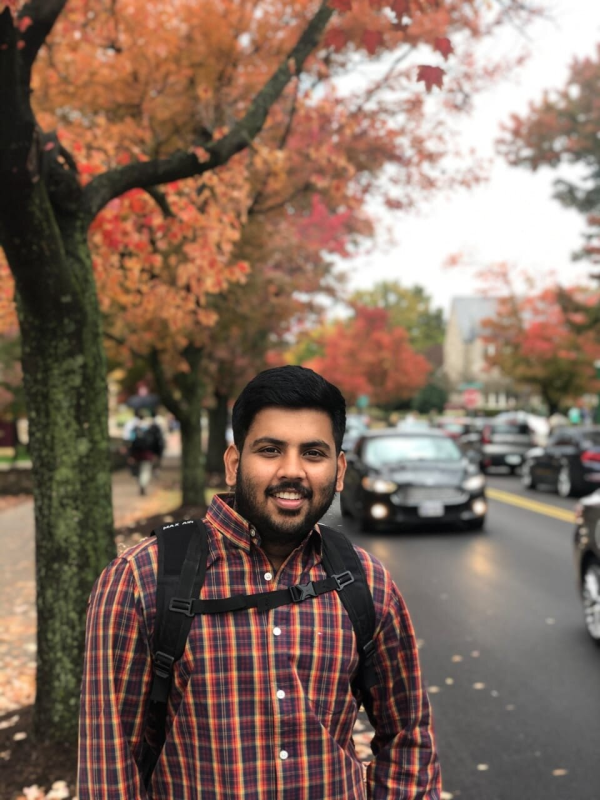

Priority


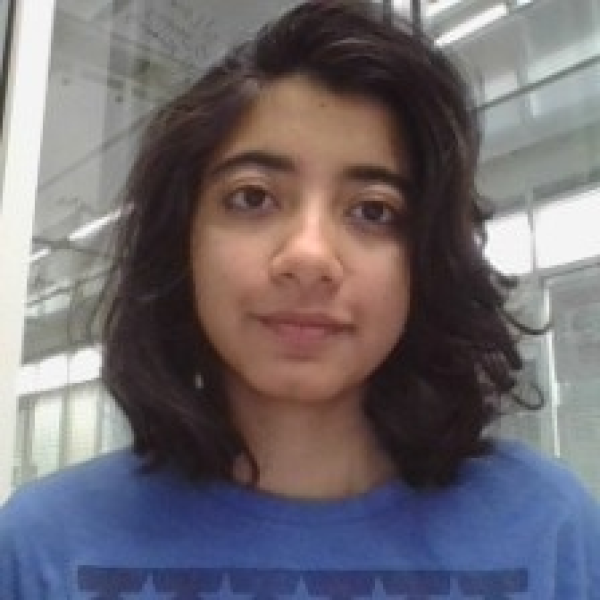

Priority


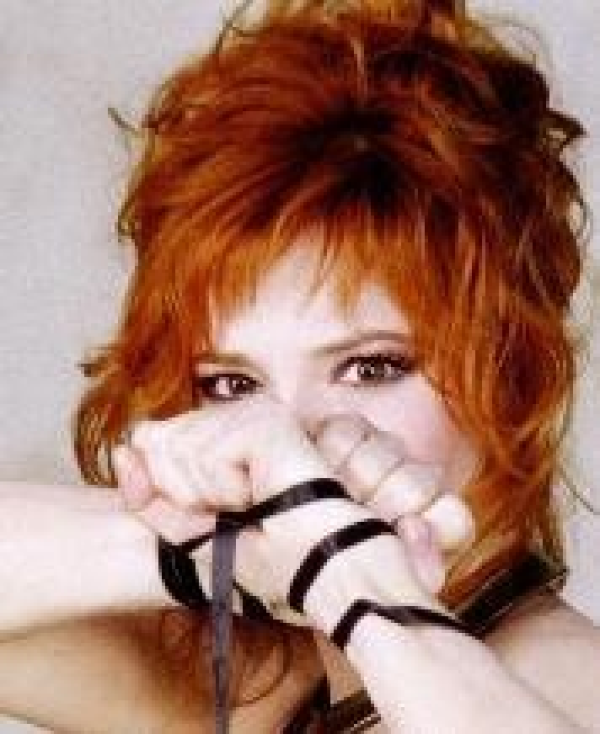

Priority


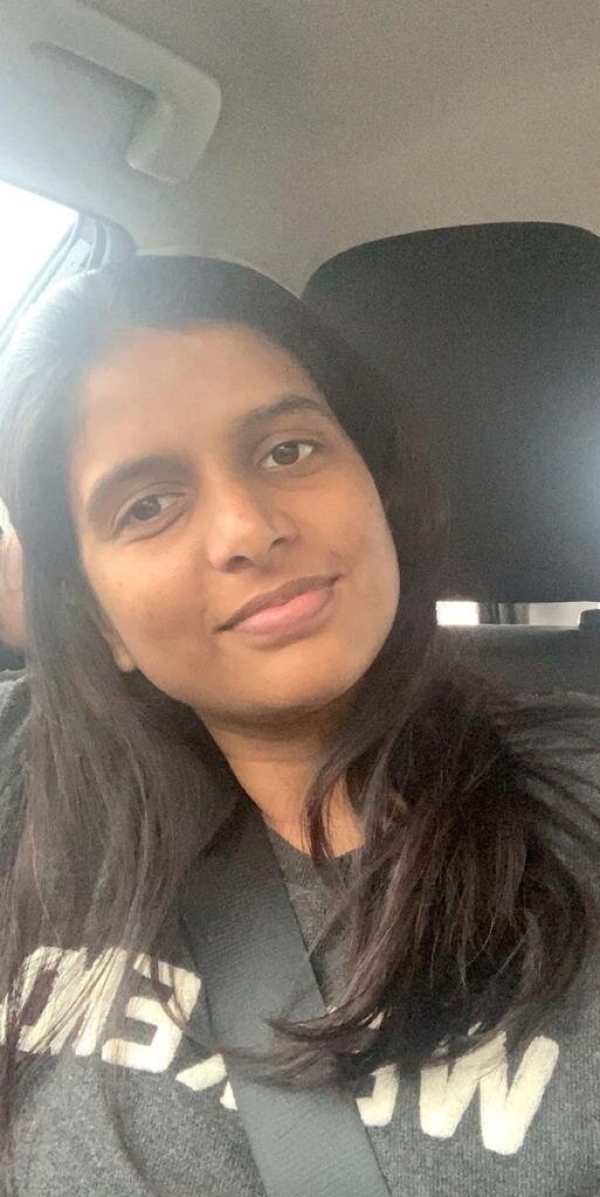

Priority


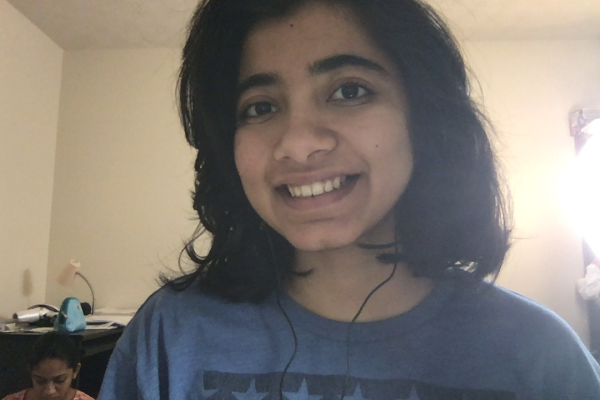

Priority


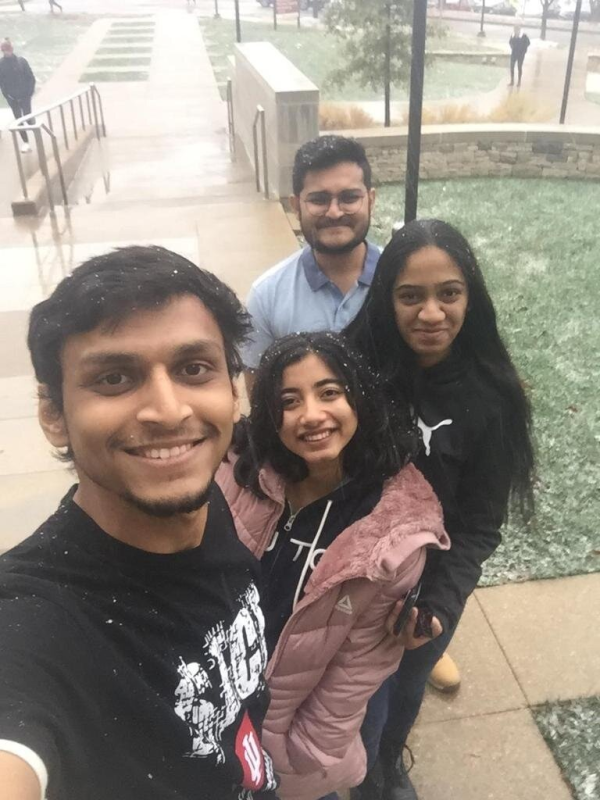

Priority


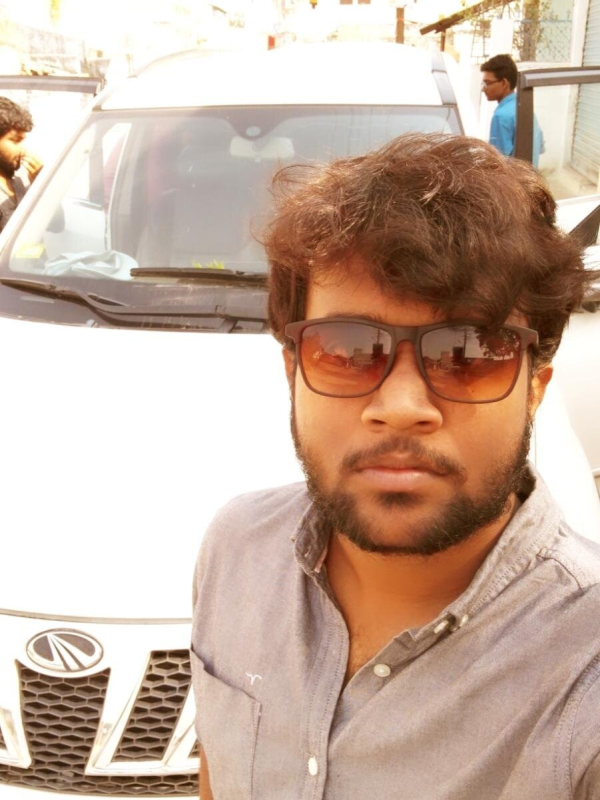

Priority


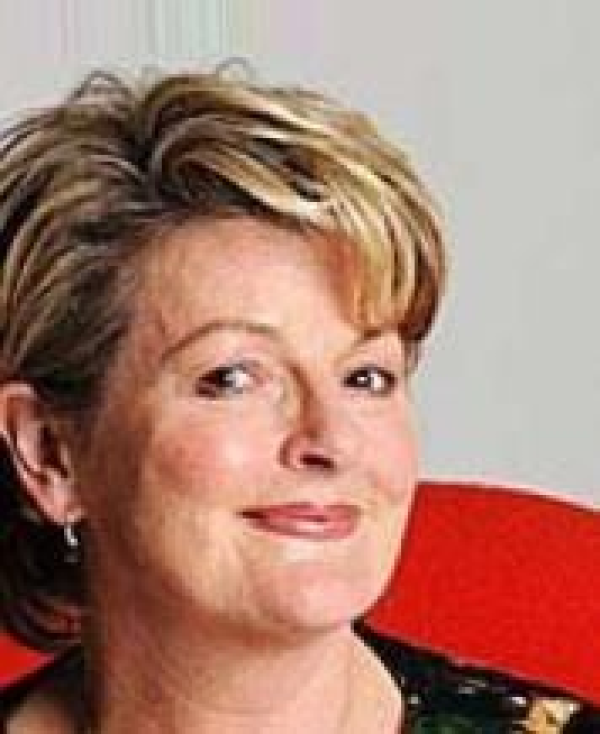

Others


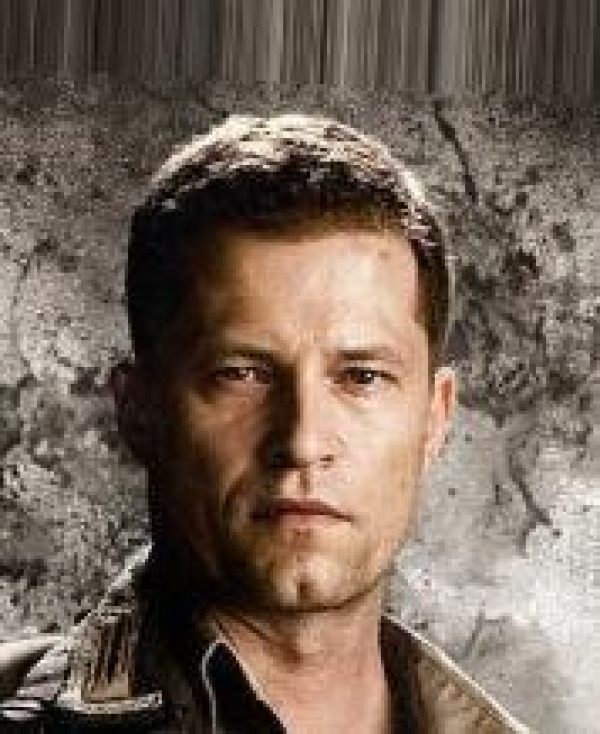

Others


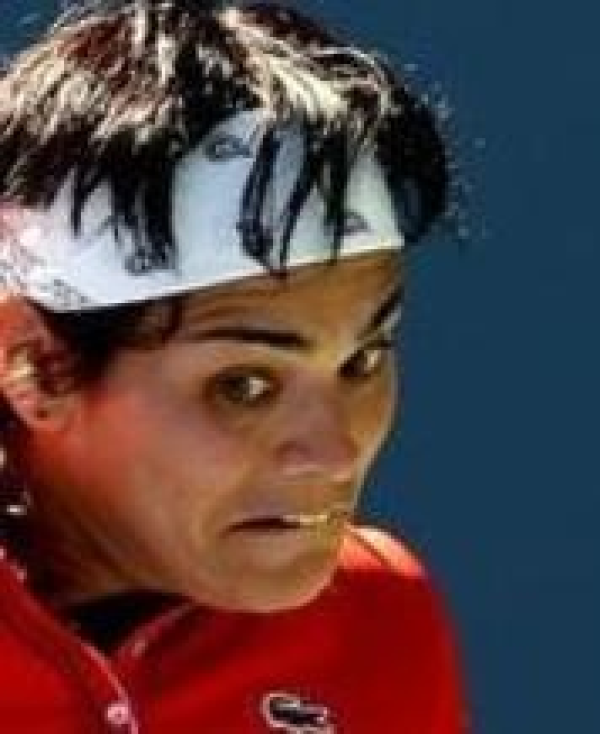

Others


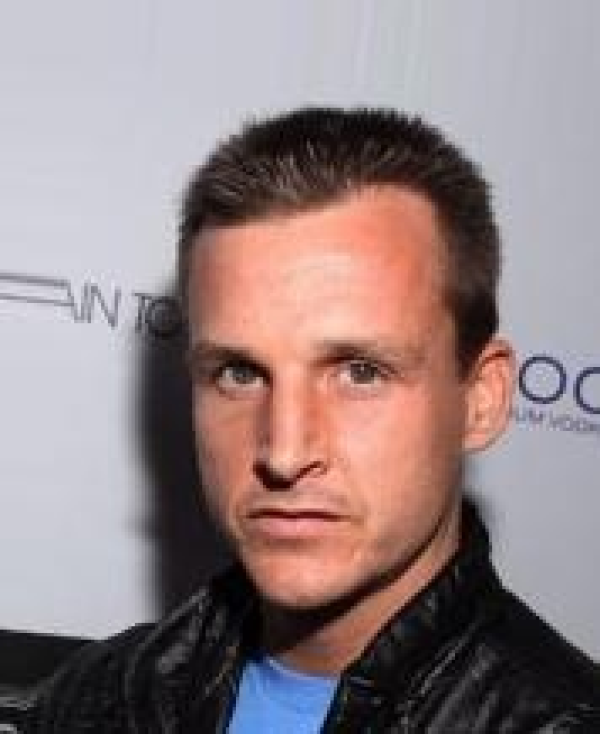

Others


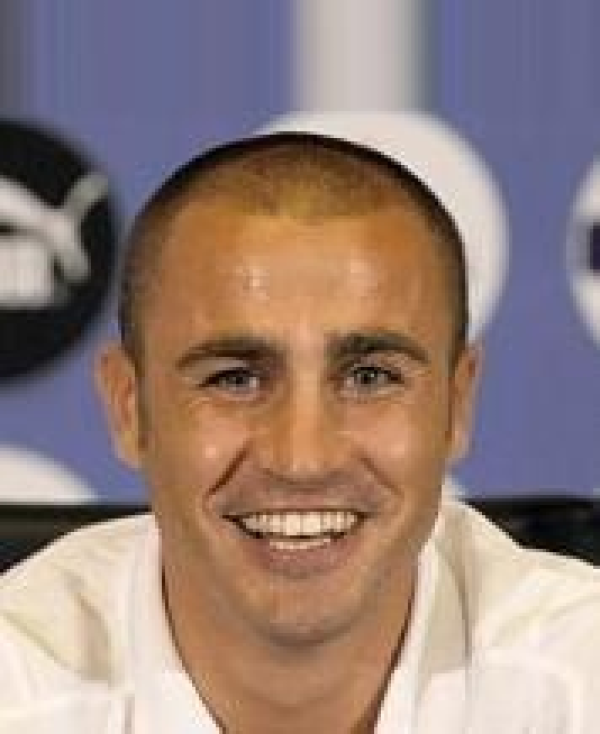

Others


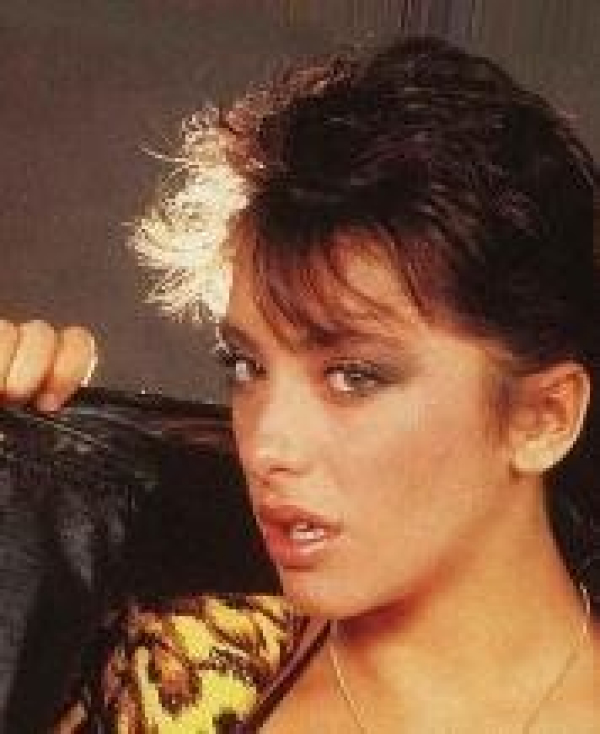

No.of images in Priority 8
No.of iamges in others 5


In [23]:
from google.colab.patches import cv2_imshow
count=0
uk=0
priorityc=0
otherc=0 
    
testPaths = list(paths.list_images('/content/drive/My Drive/AML_Project/Test1/Test1_Classified'))

for path in testPaths:
    names=[]
    count1=str(count)
    image = cv2.imread(path)
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]

    # construct a blob from the image
    imageBlob = cv2.dnn.blobFromImage(
        cv2.resize(image, (300, 300)), 1.0, (300, 300),
        (104.0, 177.0, 123.0), swapRB=False, crop=False)

    # apply OpenCV's deep learning-based face detector to localize
    # faces in the input image
    detector.setInput(imageBlob)
    detections = detector.forward()

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the
        # prediction
        confidence = detections[0, 0, i, 2]
        
        # filter out weak detections
        if confidence > 0.50 :
            # compute the (x, y)-coordinates of the bounding box for the
            # face
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # extract the face ROI
            face = image[startY:endY, startX:endX]
            (fH, fW) = face.shape[:2]

            # ensure the face width and height are sufficiently large
            if fW < 20 or fH < 20:
                continue

            # construct a blob for the face ROI, then pass the blob
            # through our face embedding model to obtain the 128-d
            # quantification of the face
            faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),
                (0, 0, 0), swapRB=True, crop=False)
            embedder.setInput(faceBlob)
            vec = embedder.forward()

            # perform classification to recognize the face
            preds = recognizer.predict_proba(vec)[0]
            j = np.argmax(preds)
            proba = preds[j]
            name = le.classes_[j]
        
            names.append(name)
            
            
            
    for i in names:
        if i=='unknown':
            uk+=1
    

    if uk== len(names) :
        cv2.imwrite('others/'+str(otherc)+'.jpg', image)
        otherc+=1
        print('Others')
        cv2_imshow(image)
    else:   
        cv2.imwrite('Priority images/'+str(priorityc)+'.jpg', image)
        #print('Boo')
        priorityc+=1
        print('Priority')
        cv2_imshow(image)
    uk=0 
    names=[]
    count+=1
print("No.of images in Priority",priorityc)
print("No.of iamges in others",otherc)

In [26]:
Priority_images_in_test1=6 # The number of priority images in the test set 
Classified_as_priority= priorityc #no.of images the model identified as priority

Accuracy= Priority_images_in_test1/Classified_as_priority
print (Accuracy*100,'percent')# Though all the priority images are correctly classified there are 2 images which are wrongly classified

75.0 percent
